# View Dataset

In [3]:
import pandas as pd

# Load data 
file_path = "med_events.csv"  
df = pd.read_csv(file_path)

# Display gen info about the dataset
print("Dataset Info:")
df.info()

# Display the first few rows of the dataset
print("\nFirst 5 Rows:")
display(df.head()) 

# Show basic statistics
print("\nSummary Statistics:")
display(df.describe(include="all")) #numeric and categorical data


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1080 entries, 0 to 1079
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   PATIENT_ID  1080 non-null   int64 
 1   DATE        1080 non-null   object
 2   PERDAY      1080 non-null   int64 
 3   CATEGORY    1080 non-null   object
 4   DURATION    1080 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 42.3+ KB

First 5 Rows:


,PATIENT_ID,DATE,PERDAY,CATEGORY,DURATION
0,1,04/26/2033,4,medA,50
1,1,07/04/2033,4,medB,30
2,1,08/03/2033,4,medB,30
3,1,08/17/2033,4,medB,30
4,1,10/13/2033,4,medB,30



Summary Statistics:


,PATIENT_ID,DATE,PERDAY,CATEGORY,DURATION
count,1080.000000,1080,1080.000000,1080,1080.00000
unique,NaN,953,NaN,2,NaN
top,NaN,08/02/2036,NaN,medA,NaN
freq,NaN,3,NaN,549,NaN
mean,50.934259,NaN,3.762963,NaN,47.37963
std,29.999542,NaN,2.139552,NaN,22.08091
min,1.000000,NaN,2.000000,NaN,20.00000
25%,24.000000,NaN,2.000000,NaN,30.00000
50%,51.500000,NaN,4.000000,NaN,50.00000
75%,78.000000,NaN,4.000000,NaN,50.00000


### Check for Missing Values

In [4]:
import pandas as pd

# Load the data
file_path = "med_events.csv"  # Update the path if needed
df = pd.read_csv(file_path)

# Check for missing values
print("\nMissing Values per Column:")
print(df.isnull().sum())

# Check percentage of missing values
print("\nPercentage of Missing Values:")
print(df.isnull().mean() * 100)



Missing Values per Column:
PATIENT_ID    0
DATE          0
PERDAY        0
CATEGORY      0
DURATION      0
dtype: int64

Percentage of Missing Values:
PATIENT_ID    0.0
DATE          0.0
PERDAY        0.0
CATEGORY      0.0
DURATION      0.0
dtype: float64


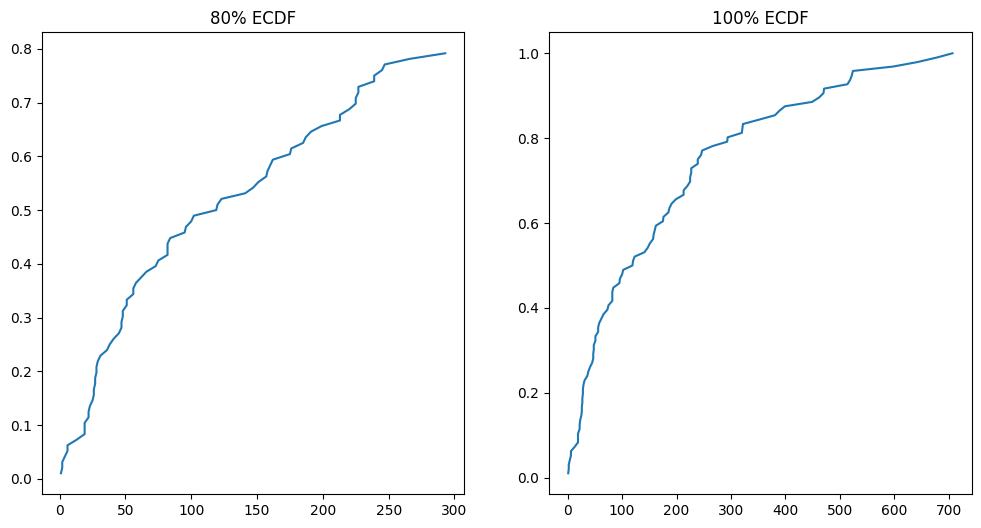

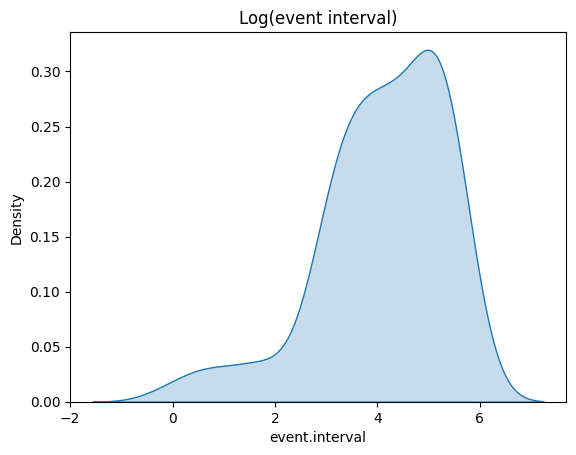

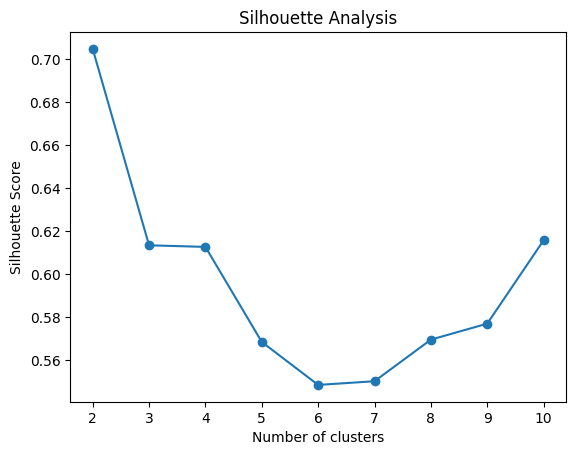

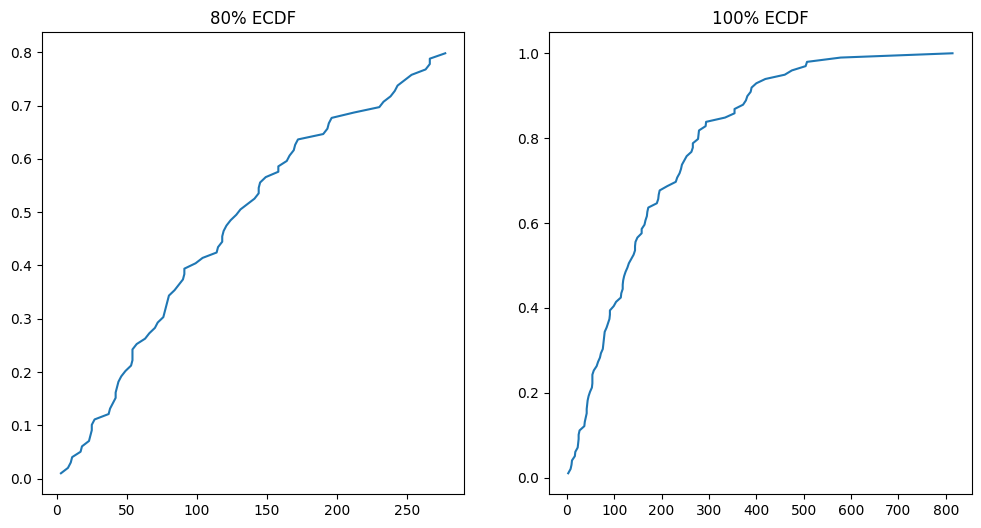

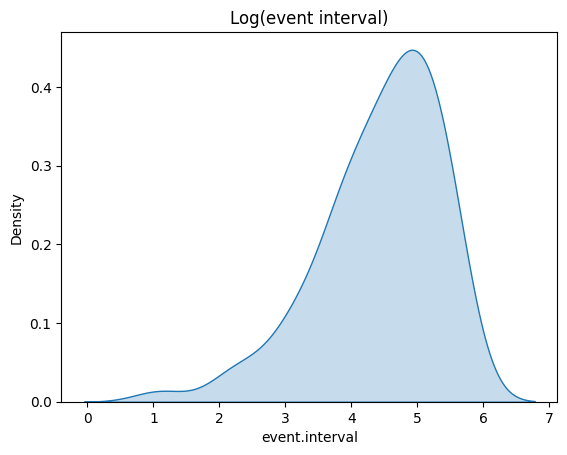

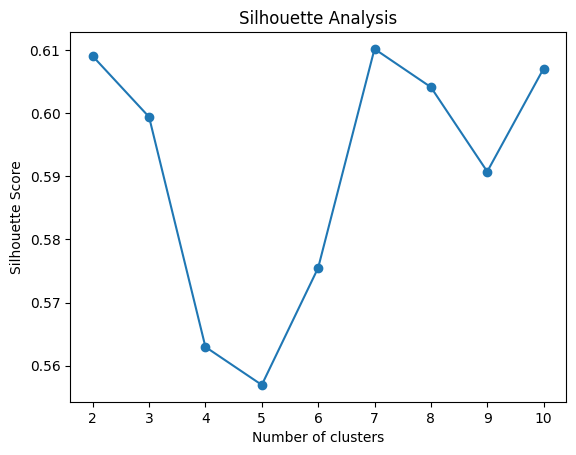

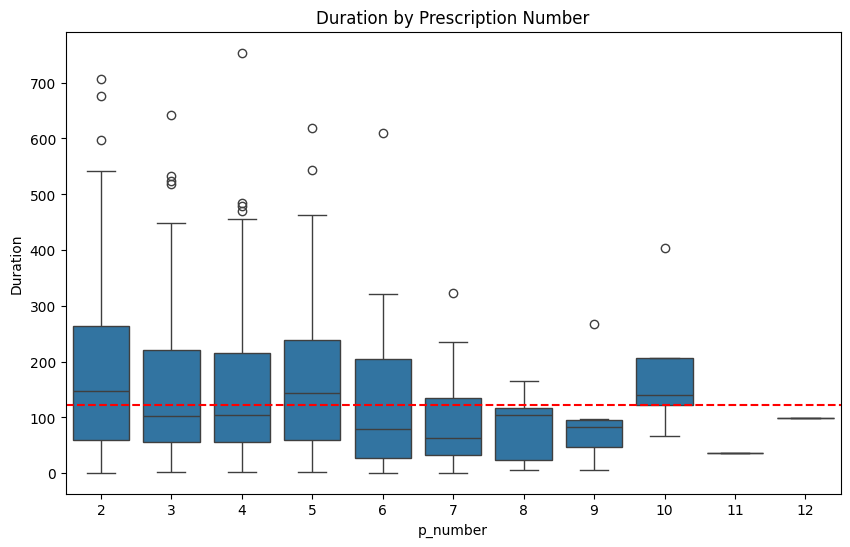

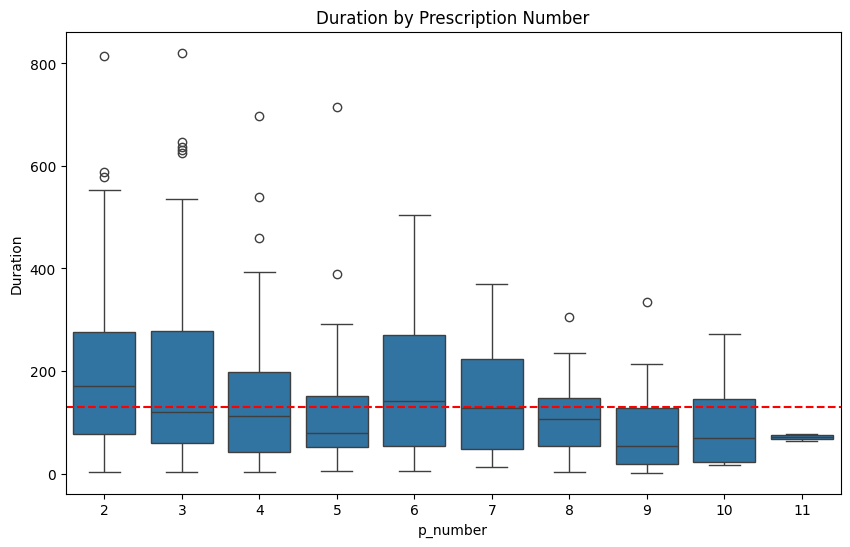

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import scale
from scipy.stats import norm
from plotly import express as px

# Load your dataset (replace this with your actual dataset)
# Example: med_events = pd.read_csv("med_events.csv")
med_events = pd.DataFrame({
    'pnr': np.random.randint(1, 100, 1080),
    'eksd': pd.date_range(start='2020-01-01', periods=1080, freq='D').strftime('%m/%d/%Y'),
    'perday': np.random.randint(1, 6, 1080),
    'ATC': np.random.choice(['medA', 'medB'], 1080),
    'dur_original': np.random.randint(1, 31, 1080)
})

# Convert 'eksd' to datetime
med_events['eksd'] = pd.to_datetime(med_events['eksd'], format='%m/%d/%Y')

# Rename columns
tidy = med_events.rename(columns={
    'pnr': 'pnr',
    'eksd': 'eksd',
    'perday': 'perday',
    'ATC': 'ATC',
    'dur_original': 'dur_original'
})

# Define the See function
def See(arg1):
    # Filter data for the specified ATC code
    C09CA01 = tidy[tidy['ATC'] == arg1].copy()
    
    # Take a random sequence of consecutive prescriptions
    Drug_see_p0 = C09CA01.copy()
    Drug_see_p1 = C09CA01.copy()
    
    # Sort and group by 'pnr'
    Drug_see_p1 = Drug_see_p1.sort_values(by=['pnr', 'eksd'])
    Drug_see_p1['prev_eksd'] = Drug_see_p1.groupby('pnr')['eksd'].shift(1)
    
    # Remove rows with NA in 'prev_eksd'
    Drug_see_p1 = Drug_see_p1.dropna(subset=['prev_eksd'])
    
    # Sample one row per 'pnr' (fixing the warning)
    Drug_see_p1 = (Drug_see_p1
                   .groupby('pnr', group_keys=False)[['pnr','eksd','prev_eksd']]
                   .apply(lambda x: x.sample(1))
                   .reset_index(drop=True))
    Drug_see_p1['event.interval'] = (Drug_see_p1['eksd'] - Drug_see_p1['prev_eksd']).dt.days.astype(float)
    
    # Calculate ECDF manually
    x = np.sort(Drug_see_p1['event.interval'])
    y = np.arange(1, len(x) + 1) / len(x)
    
    # Create a DataFrame for ECDF
    dfper = pd.DataFrame({'x': x, 'y': y})
    
    # Retain the 20% of the ECDF
    dfper = dfper[dfper['y'] <= 0.8]
    
    # Plot ECDF
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(dfper['x'], dfper['y'], label="80% ECDF")
    plt.title("80% ECDF")
    
    plt.subplot(1, 2, 2)
    plt.plot(x, y, label="100% ECDF")
    plt.title("100% ECDF")
    plt.show()
    
    # Density plot
    ni = dfper['x'].max()
    Drug_see_p2 = Drug_see_p1[Drug_see_p1['event.interval'] <= ni]
    sns.kdeplot(np.log(Drug_see_p2['event.interval']), fill=True)
    plt.title("Log(event interval)")
    plt.show()
    
    # Silhouette Score
    a = dfper[['x']].values
    silhouette_scores = []
    for n_cluster in range(2, 11):
        kmeans = KMeans(n_clusters=n_cluster, random_state=1234)
        kmeans.fit(a)
        silhouette_scores.append(silhouette_score(a, kmeans.labels_))
    
    max_cluster = np.argmax(silhouette_scores) + 2  # +2 because range starts from 2
    
    plt.plot(range(2, 11), silhouette_scores, marker='o')
    plt.title("Silhouette Analysis")
    plt.xlabel("Number of clusters")
    plt.ylabel("Silhouette Score")
    plt.show()
    
    # K-means Clustering
    kmeans = KMeans(n_clusters=max_cluster, random_state=1234)
    dfper['cluster'] = kmeans.fit_predict(dfper[['x']])
    
    # Summarize clusters
    ni2 = dfper.groupby('cluster')['x'].min().reset_index()
    ni3 = dfper.groupby('cluster')['x'].max().reset_index()
    ni4 = dfper.groupby('cluster')['x'].median().reset_index()
    
    nif = pd.merge(ni2, ni3, on='cluster')
    nif = pd.merge(nif, ni4, on='cluster')
    nif.columns = ['Cluster', 'Minimum', 'Maximum', 'Median']
    
    nif['Minimum'] = np.exp(nif['Minimum'])
    nif['Maximum'] = np.exp(nif['Maximum'])
    nif['Median'] = np.exp(nif['Median'])
    
    # Merge results
    results = pd.merge(Drug_see_p1, nif, how='cross')
    results['Final_cluster'] = np.where(
        (results['event.interval'] >= results['Minimum']) & 
        (results['event.interval'] <= results['Maximum']), 
        results['Cluster'], np.nan
    )
    results = results.dropna(subset=['Final_cluster'])
    results = results[['pnr', 'Median', 'Cluster']]
    
    # Assign clusters
    Drug_see_p1 = pd.merge(Drug_see_p1, results, on='pnr', how='left')
    Drug_see_p1['Median'] = Drug_see_p1['Median'].fillna(results['Median'].median())
    Drug_see_p1['Cluster'] = Drug_see_p1['Cluster'].fillna(0)
    Drug_see_p1['test'] = round(Drug_see_p1['event.interval'] - Drug_see_p1['Median'], 1)
    
    # Assign Duration
    Drug_see_p0 = pd.merge(Drug_see_p0, Drug_see_p1[['pnr', 'Median', 'Cluster']], on='pnr', how='left')
    Drug_see_p0['Median'] = Drug_see_p0['Median'].fillna(results['Median'].median())
    Drug_see_p0['Cluster'] = Drug_see_p0['Cluster'].fillna(0)
    
    return Drug_see_p0

# Define the see_assumption function
def see_assumption(arg1):
    arg1 = arg1.sort_values(by=['pnr', 'eksd'])
    arg1['prev_eksd'] = arg1.groupby('pnr')['eksd'].shift(1)
    Drug_see2 = arg1.groupby('pnr', group_keys=False)[['pnr','eksd','prev_eksd']].apply(lambda x: x.assign(p_number=np.arange(1, len(x) + 1))).reset_index(drop=True)
    Drug_see2 = Drug_see2[Drug_see2['p_number'] >= 2]
    Drug_see2 = Drug_see2[['pnr', 'eksd', 'prev_eksd', 'p_number']]
    Drug_see2['Duration'] = (Drug_see2['eksd'] - Drug_see2['prev_eksd']).dt.days
    Drug_see2['p_number'] = Drug_see2['p_number'].astype('category')
    
    medians_of_medians = Drug_see2.groupby('pnr')['Duration'].median().reset_index()
    
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='p_number', y='Duration', data=Drug_see2)
    plt.axhline(y=medians_of_medians['Duration'].median(), color='r', linestyle='--')
    plt.title("Duration by Prescription Number")
    plt.show()

# Example usage
medA = See("medA")
medB = See("medB")

see_assumption(medA)
see_assumption(medB)

## Insights from SEE using K-Means

### 1. Cluster Analysis:
- K-Means identified `k` clusters (optimal `k` determined using the Silhouette Score).
- Each cluster represents different groups of prescription event intervals.
- The median event interval for each cluster provides insight into common prescription patterns.

### 2. Limitations:
- K-Means assumes spherical clusters and struggles with varying densities.
- The presence of noise and outliers may impact the centroids significantly.
- Cluster assignment is strict; all points belong to one of the `k` clusters, even if they don’t fit well.

### 3. Observations:
- The distribution of event intervals shows some natural groupings, but K-Means enforces strict separations.
- Silhouette scores indicate a moderate clustering quality but might be improved with another method.

---
